# ETL efficiency

### Dimensions

Inner radius of disk: 315mm (eta 1.659)

Outer radius of disk: 1185mm (eta 2.950)

In [126]:
import math
import time
import os.path
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import ROOT
from millisim.Environment import Environment
from millisim.Integrator import Integrator
from millisim.Detector import *
import millisim.Drawing as Drawing
from millisim.MilliTree import MilliTree
from centers import *

In [127]:
def getEta(radius):
    return -math.log(math.tan(math.atan(radius/3000.)/2))

class ETLSensor(object):
    '''
    samllest entity of the ETL detector
    '''
    def __init__(self, dist_to_origin, x, y, width, height):
        # if width or height are None, detector plane has infinite extent
        # width corresponds to eta-hat direction (self.unit_w)
        # height corresonds to phi-hat direction (self.unit_v)

        self.dist_to_origin = float(dist_to_origin)
        #self.eta = float(eta)
        #self.phi = float(phi)
        self.width = float(width) if width is not None else None
        self.height = float(height) if height is not None else None
        self.x = x
        self.y = y

        theta = 0.0
        z = dist_to_origin

        self.center = np.array([x,y,z])
        self.norm = self.center / np.linalg.norm(self.center)

        self.unit_v = np.array([0., 1., 0.])
        self.unit_w = np.array([1., 0., 0.])#cross(self.norm, self.unit_v)
        self.hit = False
        

    # get the four corners, for drawing purposes
    def get_corners(self):
        if self.width is None or self.height is None:
            raise Exception("Can't get corners of an infinite detector!")

        c1 = self.center + self.unit_w * self.width/2 + self.unit_v * self.height/2
        c2 = self.center - self.unit_w * self.width/2 + self.unit_v * self.height/2
        c3 = self.center - self.unit_w * self.width/2 - self.unit_v * self.height/2
        c4 = self.center + self.unit_w * self.width/2 - self.unit_v * self.height/2
        
        return c1,c2,c3,c4

    def get_line_segments(self):
        c1,c2,c3,c4 = self.get_corners()
        return [(c1,c2),(c2,c3),(c3,c4),(c4,c1)]

    def draw(self, ax, is3d=False, isXZ=False, **kwargs):
        if self.width is None or self.height is None:
            raise Exception("Can't draw an infinite detector!")
        if "color" not in kwargs and "c" not in kwargs:
            kwargs["color"] = 'k'
        # NOTE: y and z axes flipped, for consistency with Drawing module (see Drawing.Draw3Dtrajs)
        for p1, p2 in self.get_line_segments():
            if is3d:
                ax.plot(xs=[p1[0],p2[0]], ys=[p1[2],p2[2]], zs=[p1[1],p2[1]], **kwargs)
            elif isXZ:
                ax.plot([p1[2],p2[2]],[p1[0],p2[0]], **kwargs)
            else:
                ax.plot([p1[0],p2[0]],[p1[1],p2[1]], **kwargs)

    def transform_from_detcoords(self, v, w, n=None):
        if n is None:
            n = self.dist_to_origin
        return n*self.norm + v*self.unit_v + w*self.unit_w

    def find_intersection(self, traj, tvec=None):
        # find the intersection with a plane with normal norm
        # and distance to origin dist. returns None if no intersection
        # ETL with a X-Y plane is a bit simpler than the general case

        dists = traj[2, :]
        idx = np.argmax(dists > self.dist_to_origin)

        if idx == 0:
            return None

        p1 = traj[:3,idx-1]
        p2 = traj[:3,idx]
        
        delta = p2 - p1
        frac = delta/delta[2]
        intersect = frac*(self.dist_to_origin-p1[2]) + p1
        
        v = np.dot(intersect,self.unit_v)
        w = np.dot(intersect,self.unit_w)
        if ((self.x - self.width/2) < w < (self.x + self.width/2)) and ((self.y - self.height/2) < v < (self.y+self.height/2)):
            unit = (p2-p1)/np.linalg.norm(p2-p1)
            theta = np.arccos(np.dot(unit,self.norm))
            
            projW = np.dot(unit,self.unit_w)
            projV = np.dot(unit,self.unit_v)
            
            thW = np.arcsin(projW / np.linalg.norm(unit-projV*self.unit_v))
            thV = np.arcsin(projV / np.linalg.norm(unit-projW*self.unit_w))

            t = None
            if tvec is not None:
                t = tvec[idx-1] + frac * (tvec[idx] - tvec[idx-1])
            
            pInt = traj[3:,idx-1] + frac * (traj[3:,idx] - traj[3:,idx-1])

            return {
                "x_int" : intersect,
                "t_int" : t,
                "p_int" : pInt,
                "v" : v,
                "w" : w,
                "theta" : theta,
                "theta_w" : thW,
                "theta_v" : thV,
                }

        return None

class ETLFace(object):
    '''
    One face of the ETL detector
    '''
    def __init__(self, dist_to_origin, centers, sensor, offset_x=0, offset_y=0, mirror=False):
        self.dist_to_origin = dist_to_origin
        self.sensor = sensor
        self.centers = centers
        self.offset_x = offset_x
        self.offset_y = offset_y
        self.sensors  = [ ETLSensor(dist_to_origin=dist_to_origin, x=x/1000., y=y/1000., width=sensor.width, height=sensor.height) for x,y in centers  ]
        self.x = np.array([x/1000. for x,y in centers])
        self.y = np.array([y/1000. for x,y in centers])
        if mirror:
            self.sensors += [ ETLSensor(dist_to_origin=dist_to_origin, x=-x/1000., y=y/1000., width=sensor.width, height=sensor.height) for x,y in centers  ]
            self.x = np.append(self.x, [-x/1000. for x,y in centers] )
            self.y = np.append(self.y, [y/1000. for x,y in centers] )
        return
        
    def draw(self, ax, is3d=False, isXZ=False, **kwargs):
        if "color" not in kwargs and "c" not in kwargs:
            kwargs["color"] = 'k'
        try:
            tmpColor = kwargs["color"]
        except KeyError:
            tmpColor = kwargs["c"]
        for sensor in self.sensors:
            if sensor.hit:
                #print "Have a sensor that was hit!"
                kwargs["color"] = 'green'
                #kwargs["fc"] = (1,0,0,0.5)
            else:
                kwargs["color"] = tmpColor
                #kwargs["fc"] = None
            # NOTE: y and z axes flipped, for consistency with Drawing module (see Drawing.Draw3Dtrajs)
            for p1, p2 in sensor.get_line_segments():
                if is3d:
                    fs = 'full' if sensor.hit else 'none'
                    ax.plot(xs=[p1[0],p2[0]], ys=[p1[2],p2[2]], zs=[p1[1],p2[1]], fillstyle=fs, **kwargs)
                elif isXZ:
                    ax.plot([p1[2],p2[2]],[p1[0],p2[0]], **kwargs)
                else:
                    ax.plot([p1[0],p2[0]],[p1[1],p2[1]], **kwargs)
        
    def find_intersection(self, traj, tvec=None):
        dists = traj[2, :]
        idx = np.argmax(dists > self.dist_to_origin)

        if idx == 0:
            return None

        p1 = traj[:3,idx-1]
        p2 = traj[:3,idx]
        
        delta = p2 - p1
        frac = delta/delta[2]
        intersect = frac*(self.dist_to_origin-p1[2]) + p1
        
        #print "intersect", intersect
        
        for sensor in self.sensors:
            v = np.dot(intersect,sensor.unit_v)
            w = np.dot(intersect,sensor.unit_w)
            if ((sensor.x - sensor.width/2) < w < (sensor.x + sensor.width/2)) and ((sensor.y - sensor.height/2) < v < (sensor.y+sensor.height/2)):
                unit = (p2-p1)/np.linalg.norm(p2-p1)
                theta = np.arccos(np.dot(unit,sensor.norm))
            
                projW = np.dot(unit,sensor.unit_w)
                projV = np.dot(unit,sensor.unit_v)
            
                thW = np.arcsin(projW / np.linalg.norm(unit-projV*sensor.unit_v))
                thV = np.arcsin(projV / np.linalg.norm(unit-projW*sensor.unit_w))

                t = None
                if tvec is not None:
                    t = tvec[idx-1] + frac * (tvec[idx] - tvec[idx-1])
            
                pInt = traj[3:,idx-1] + frac * (traj[3:,idx] - traj[3:,idx-1])

                sensor.hit = True
                
                return {
                    "x_int" : intersect,
                    "t_int" : t,
                    "p_int" : pInt,
                    "v" : v,
                    "w" : w,
                    "theta" : theta,
                    "theta_w" : thW,
                    "theta_v" : thV,
                    }

        return {"x_int" : intersect}
    
    def find_intersection_fast(self, x, y, debug=False):
        
        #return ((self.x-self.sensor.width/2)<x).any() & ((self.x+self.sensor.width/2)>x).any() & ((self.y-self.sensor.height/2)<y).any() & ((self.y+self.sensor.height/2)>y).any()
        for sensor in self.sensors:
            if debug: print sensor.x, sensor.width, sensor.y, sensor.width
            if ((sensor.x - sensor.width/2) < x < (sensor.x + sensor.width/2)) and ((sensor.y - sensor.height/2) < y < (sensor.y+sensor.height/2)):
                
                return True

        return False



In [128]:


mode = "VIS"
ntrajs = 20
pt_spect_filename = "../p_eta_dist/combined_PtSpect_Eta0p16.root"
dt = 0.1   #timestep in ns
max_nsteps = 10000
cutoff = 4.
use_var_dt = False
bfield_type = "cms"

particleQ = 1.0  # in electron charge units
particleM = 105. # in MEV

distToDetector = 3.
eta = 2.0 # should be different
rock_begins = 16. #??

detWidth = 1.0
detHeight = 1.0
detDepth = 1.0

etabounds = (1.659, 2.950)  ## full ETL disk.
#etabounds = (1.7, 2.8)  ## required coverage (?)
#etabounds = (1.7, 2.0)  ## required coverage (?)
#etabounds = (2.0, 2.5) # to check gaps
ptCut = 5. # 25
phibounds = (-np.pi/2, np.pi/2)
#phibounds = (0, np.pi/2)



useCustomMaterialFunction = False
#useCustomIntersectionFunction = False
useCustomOutput = False

In [146]:
env = Environment(
    mat_setup = 'cms',
    bfield = bfield_type,
    bfield_file = "../bfield/bfield_coarse.pkl",
    rock_begins = rock_begins,
    rock_ends = distToDetector-0.10,
    mat_function = matFunction if useCustomMaterialFunction else None
)

## No magnetic field, for tests
#env = Environment(
#    mat_setup = 'cms',
#    bfield = None,
#    rock_begins = rock_begins,
#    rock_ends = distToDetector-0.10,
#    mat_function = matFunction if useCustomMaterialFunction else None
#)

itg = Integrator(
    environ = env,
    Q = particleQ,
    m = particleM,
    dt = dt,
    nsteps = max_nsteps,
    cutoff_dist = cutoff,
    cutoff_axis = 'z',
    use_var_dt = use_var_dt,
    lowv_dx = 0.01,
    multiple_scatter = 'pdg',
    do_energy_loss = True,
    randomize_charge_sign = False,
    )

plusZ1 = PlaneDetector(
    dist_to_origin = 3,
    eta = float("inf"),
    phi = 0.0,
    width = 1.13,
    height = 1.13,
)

plusZ2 = PlaneDetector(
    dist_to_origin = 3.1,
    eta = float("inf"),
    phi = 0.0,
    width = 1.13,
    height = 1.13,
)

minusZ = PlaneDetector(
    dist_to_origin = -3,
    eta = float("inf"),
    phi = 0.0,
    width = 2.5,
    height = 2.5,
)

ETLmod1 = ETLSensor(
    dist_to_origin = 3,
    x = 0.6,
    y = 0.0,
    width = 1.2,
    height = 2.26,
)

ETLmod2 = ETLSensor(
    dist_to_origin = 3.1,
    x = 0.6,
    y = 0.,
    width = 1.2,
    height = 2.26,
)

sensor = ETLSensor(
    dist_to_origin = 3,
    x = 0,
    y = 0,
    width = 0.0425,
    height = 0.022,
)

from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

with open('database.yaml') as f:
    database = load(f, Loader=Loader)

with open('database_TDR.yaml') as f:
    databaseTDR = load(f, Loader=Loader)

disk = database['TAMALES'] # no place reserved for services / MT connectors, but 6mm on edge of the disk
diskTDR = databaseTDR['TDR']

### TAMALES
# Disk 1 on the z+ side
TAMALES_face_plus_front1 = ETLFace(2.99825, disk['disk1']['front'], sensor, mirror=True)
TAMALES_face_plus_back1 = ETLFace(3.0055, disk['disk1']['back'], sensor, mirror=True)

# Disk 2 on the z+ side. Can have some offset to fill in inter-sensor and inter-module gaps
TAMALES_face_plus_front2 = ETLFace(3.02075, disk['disk2']['front'], sensor, offset_x=0.02, mirror=True)
TAMALES_face_plus_back2 = ETLFace(3.0285, disk['disk2']['back'], sensor, offset_y=0.02, mirror=True)

### TDR
# Disk 1 on the z+ side
TDR_face_plus_front1 = ETLFace(2.99825, diskTDR['disk1']['front'], sensor)
TDR_face_plus_back1 = ETLFace(3.0055, diskTDR['disk1']['back'], sensor)

# Disk 2 on the z+ side. Can have some offset to fill in inter-sensor and inter-module gaps
TDR_face_plus_front2 = ETLFace(3.02075, diskTDR['disk2']['front'], sensor, offset_x=0.02)
TDR_face_plus_back2 = ETLFace(3.0285, diskTDR['disk2']['back'], sensor, offset_y=0.02)


### This is what's used in the muon study below, and shown in the 3D plots
face_plus_front1 = TAMALES_face_plus_front1
face_plus_back1  = TAMALES_face_plus_back1
face_plus_front2 = TAMALES_face_plus_front2
face_plus_back2  = TAMALES_face_plus_back2

## for debugging
#ETLmodules = [ ETLSensor(dist_to_origin=3, x=x/1000., y=y/1000., width=0.0425, height=0.022) for x,y in centers  ]


In [147]:
# do you want to VISualize, or collect STATS?

if mode=="VIS":
    trajs = []
if mode=="STATS":
    # in STATS mode, this is the number of hits on the detector to generate
    # the total number of trajectories simulated will be greater
    trajs = []
    print "Simulating {0} hits on the detector.".format(ntrajs)
    print 
visWithStats = False

if mode=="STATS":
    print "Outputting to "+outname
# make sure numbers are new each run
seed = 0
ROOT.gRandom.SetSeed(seed)
np.random.seed(seed)

rootfile = ROOT.TFile(pt_spect_filename)
# this is a 1D pT distribution (taken from small-eta events)
pt_dist = rootfile.Get("pt")

mt = MilliTree()

# setup output file
suffix = sys.argv[1] if len(sys.argv) > 1 else "test"
try:
    os.makedirs("output_data")
except:
    pass
outname = "output_data/output_{0}.txt".format(suffix)
outnameCustom = "customOutput_{0}.txt".format(suffix)



In [148]:
if mode=="STATS":
    # if file already exists, check if we want to overwrite or append
    if os.path.isfile(outname):
        ow = 'q'
        while ow not in 'yYnN':
            ow = raw_input("Overwrite file? (y/n) ")
        if ow in 'yY':
            txtfile = open(outname,'w')
            if useCustomOutput:
                txtfile2 = open(outnameCustom, 'w')
        else:
            print "OK, appending"
            txtfile = open(outname,'a')
            if useCustomOutput:
                txtfile2 = open(outnameCustom, 'a')
    else:
        txtfile = open(outname,'w')
        if useCustomOutput:
            txtfile2 = open(outnameCustom, 'w')
    txtfile.close()
    if useCustomOutput:
        txtfile2.close()


starttime = time.time()

intersects = []
bar_intersects = []
ntotaltrajs = 0

In [149]:
# loop until we get ntrajs trajectories (VIS) or hits (STATS)
statistics = [0,0,0,0,0] # maximum 4 hits
nTraj = 0
nMeas = 0
histogram = []
eta_distribution = []
eta_passed = []
pt_distribution  = []
phi_distribution = []
phi_passed = []
intersect_xy = []
while len(trajs)<ntrajs:
    nTraj += 1
    magp = ROOT.Double(-1)
    eta = ROOT.Double(-1)

    etalow =  etabounds[0]
    etahigh =  etabounds[1]

    # draw random pT values from the distribution. Set minimum at 10 GeV
    while magp < ptCut:
        magp = pt_dist.GetRandom()

    # eta distribution is uniform for small eta
    eta = np.random.rand()*(etahigh-etalow) + etalow
    eta_distribution.append(eta)
    pt_distribution.append(magp)

    th = 2*np.arctan(np.exp(-eta))
    # magp = magp/np.sin(th)
    phimin, phimax =  phibounds
    phi = np.random.rand() * (phimax-phimin) + phimin
    phi_distribution.append(phi)
    itg.Q *= np.random.randint(2)*2 - 1 
    #phi *= itg.Q/abs(itg.Q)

    # convert to cartesian momentum in MeV
    p = 1000*magp * np.array([np.sin(th)*np.cos(phi),np.sin(th)*np.sin(phi),np.cos(th)])
    x0 = np.array([0,0,0,p[0],p[1],p[2]])
    
    # simulate until nsteps steps is reached, or the particle passes x=10
    traj,tvec = itg.propagate(x0)
    ntotaltrajs += 1
    if mode=="VIS":
        trajs.append(traj)
        print len(trajs)
    
    
    nHits = 0
    for i_face, face in enumerate([face_plus_front1, face_plus_back1, face_plus_front2, face_plus_back2]):
        idict = face.find_intersection(traj, tvec)
        if i_face==0: intersect_xy.append((idict['x_int'][0], idict['x_int'][1]))
        if idict.has_key("t_int"):
            nHits+=1
            eta_passed.append(eta)
            phi_passed.append(phi)
            continue
    
    if nHits>4: print "Weird!"
    histogram.append(nHits)
    print len(trajs), ": p =",magp, ", eta =", eta, ", phi =", phi
    statistics[nHits] += 1
    
    if nHits>0:
        nMeas += 1
        print "Intersected, current efficiency =", float(nMeas)/nTraj
        

endtime = time.time()

1
1 : p = 12.8339000464 , eta = 2.36751823357 , phi = 0.676037332526
Intersected, current efficiency = 1.0
2
2 : p = 13.023279961 , eta = 2.76660779235 , phi = 1.09092351151
Intersected, current efficiency = 1.0
3
3 : p = 14.6934982018 , eta = 2.49284929997 , phi = -0.196075558587
Intersected, current efficiency = 1.0
4
4 : p = 13.5081151337 , eta = 1.73221645372 , phi = -0.714221314787
Intersected, current efficiency = 1.0
5
5 : p = 16.1760547929 , eta = 2.45685791884 , phi = -0.223779725814
Intersected, current efficiency = 1.0
6
6 : p = 21.037953554 , eta = 1.79179659607 , phi = -1.28059519428
Intersected, current efficiency = 1.0
7
7 : p = 12.9751052994 , eta = 2.4185173936 , phi = 1.04001939495
Intersected, current efficiency = 1.0
8
8 : p = 15.1222606129 , eta = 1.65907146571 , phi = -0.591058548553
9
9 : p = 15.1564271047 , eta = 2.59390041887 , phi = -0.317221307536
Intersected, current efficiency = 0.888888888889
10
10 : p = 13.417922234 , eta = 2.2093608915 , phi = -0.0841297

Efficiency: 0.0
Total time: 2.13 sec
Time/Hit: 0.11 sec


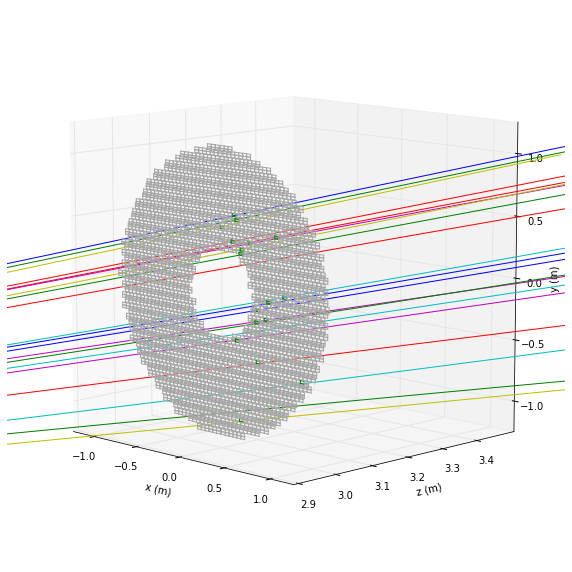

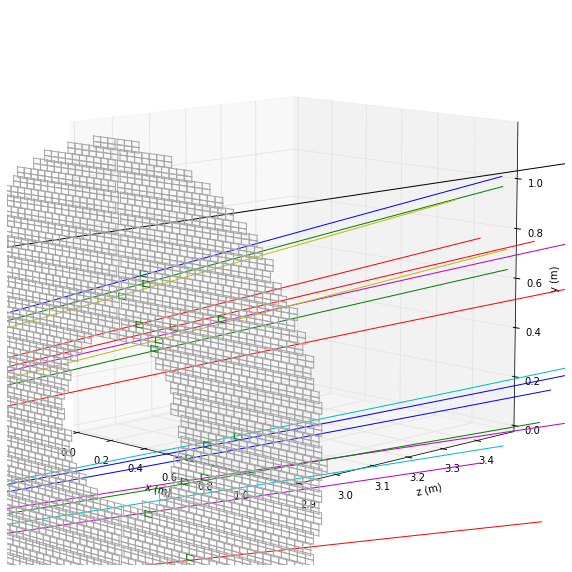

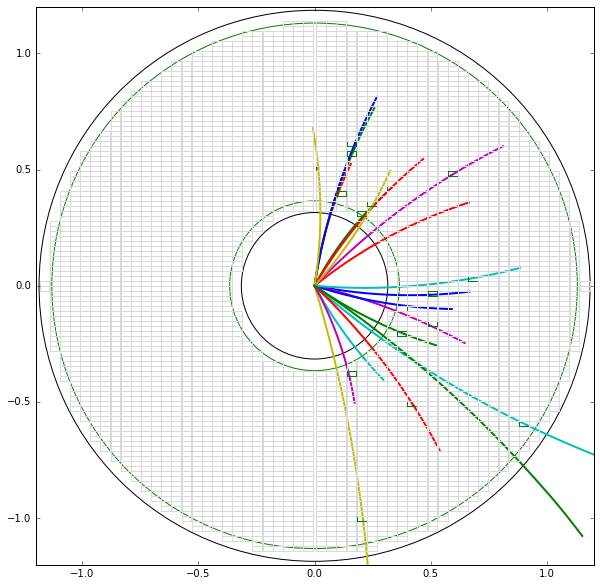

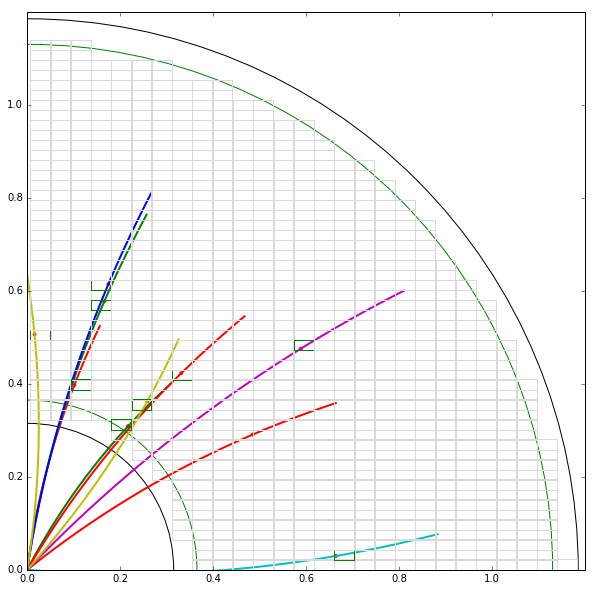

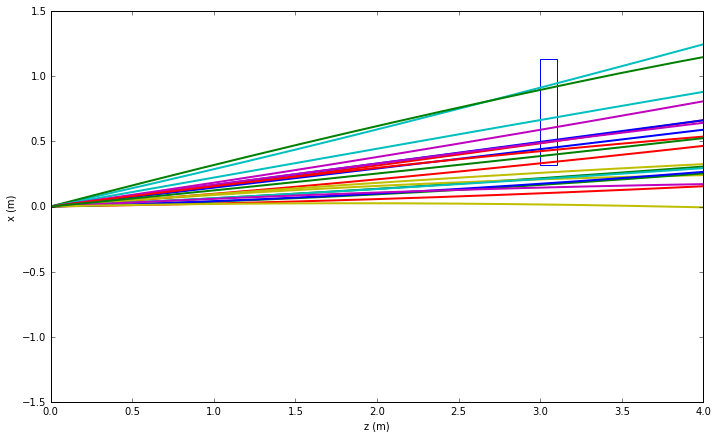

In [150]:
print "Efficiency:", float(len(intersects))/ntotaltrajs
print "Total time: {0:.2f} sec".format(endtime-starttime)
print "Time/Hit: {0:.2f} sec".format((endtime-starttime)/ntrajs)

mt.Write("output_data/output_{0}.root".format(suffix))

fid = ROOT.TFile("output_data/output_{0}.root".format(suffix), "UPDATE")

hhits = ROOT.TH1F("hhits","",1,0,2)
hsims = ROOT.TH1F("hsims","",1,0,2)
hhits.Fill(1, ntrajs)
hsims.Fill(1, ntotaltrajs)
hhits.Write()
hsims.Write()

fid.Close()

if mode=="VIS" or visWithStats:
    colors = ['r','g','b','c','m','y']
    
    ## 3D
    plt.figure(num=1, figsize=(10,10))
    Drawing.Draw3Dtrajs(trajs)    

    face_plus_front1.draw(plt.gca(), is3d=True, c='0.65')
    face_plus_back1.draw(plt.gca(), is3d=True, c='0.65')
    
    plt.gca().set_xlim(-1.2, 1.2)
    plt.gca().set_ylim(2.9, 3.5)
    plt.gca().set_zlim(-1.2, 1.2)
    
    plt.gca().view_init(elev=10., azim=-45)

    ### 3D
    plt.figure(num=2, figsize=(10,10))
    Drawing.Draw3Dtrajs(trajs)    

    face_plus_front1.draw(plt.gca(), is3d=True, c='0.65')
    face_plus_back1.draw(plt.gca(), is3d=True, c='0.65')
    
    plt.gca().set_xlim(0, 1.2)
    plt.gca().set_ylim(2.9, 3.5)
    plt.gca().set_zlim(0, 1.2)
    
    plt.gca().view_init(elev=10., azim=-45)
    

    ## 2D
    plt.figure(num=3, figsize=(10,10))
    Drawing.DrawXYslice(trajs)
    face_plus_front1.draw(plt.gca(), c='0.85')
    face_plus_back1.draw(plt.gca(), c='0.85')
    
    for int_xy in intersect_xy:
        plt.gca().add_patch(plt.Circle((int_xy[0], int_xy[1]), 0.003,fill='full', facecolor='red', edgecolor='red'))

    disk_inner = plt.Circle((0, 0), 0.315,fill=None, edgecolor='black')
    disk_outer = plt.Circle((0, 0), 1.185,fill=None, edgecolor='black')
    coverage_inner = plt.Circle((0, 0), 0.365,fill=None, edgecolor='green')
    coverage_outer = plt.Circle((0, 0), 1.130,fill=None, edgecolor='green')
        
    plt.gca().add_patch(disk_inner)
    plt.gca().add_patch(disk_outer)
    plt.gca().add_patch(coverage_inner)
    plt.gca().add_patch(coverage_outer)
    
    plt.gca().set_xlim((-1.2,1.2))
    plt.gca().set_ylim((-1.2,1.2))
    
    plt.figure(num=4, figsize=(10,10))
    Drawing.DrawXYslice(trajs)
    face_plus_front1.draw(plt.gca(), c='0.85')
    face_plus_back1.draw(plt.gca(), c='0.85')
    
    for int_xy in intersect_xy:
        plt.gca().add_patch(plt.Circle((int_xy[0], int_xy[1]), 0.003,fill='full', facecolor='red', edgecolor='red'))

    disk_inner = plt.Circle((0, 0), 0.315,fill=None, edgecolor='black')
    disk_outer = plt.Circle((0, 0), 1.185,fill=None, edgecolor='black')
    coverage_inner = plt.Circle((0, 0), 0.365,fill=None, edgecolor='green')
    coverage_outer = plt.Circle((0, 0), 1.130,fill=None, edgecolor='green')
    
    plt.gca().add_patch(disk_inner)
    plt.gca().add_patch(disk_outer)
    plt.gca().add_patch(coverage_inner)
    plt.gca().add_patch(coverage_outer)
    
    plt.gca().set_xlim((0,1.2))
    plt.gca().set_ylim((0,1.2))
    
    plt.figure(num=5, figsize=(11.7,7))
    Drawing.DrawXZslice(trajs)#, drawBFieldFromEnviron=env, drawColorbar=True)
    #face_plus_front1.draw(plt.gca(), isXZ=True, c='0.65')
    
    outline = [
        [3, 0.315],
        [3, 1.13],
        [3.1, 1.13],
        [3.1, 0.315]
    ]
    upper = plt.Polygon(outline, closed=True, fill=None, edgecolor='b')
    plt.gca().add_patch(upper)
    plt.gca().set_xlim((0,4))
    plt.gca().set_ylim((-1.5,1.5))
    
    plt.show()

- above 99% efficient for eta 2-2.5
- ~87% efficient for eta 1.659 and 2.950
- 96% eta 1.7-2.8, 70% have at least two hits

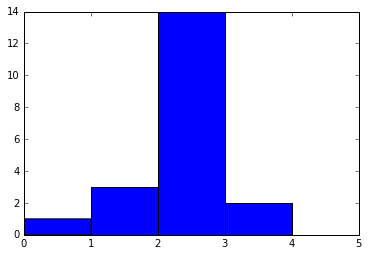

In [28]:
h, x_edge, img = plt.hist(histogram, bins=5, range=[0,5])


In [ ]:
print "No hit:", h[0]/h.sum()
print "At least one hit:", h[1:].sum()/h.sum()
print "At least two hits:", h[2:].sum()/h.sum()

In [ ]:
h, x_edge, y_edge, img = plt.hist2d(pt_distribution, eta_distribution)

In [ ]:
plt.hist(eta_distribution)

In [ ]:
plt.hist(pt_distribution)

In [ ]:
h, x_edge, y_edge, img = plt.hist2d(phi_distribution, eta_distribution)

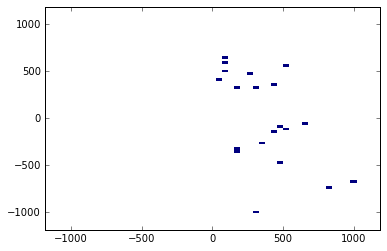

In [29]:
# all muons
theta = 2*np.arctan(np.exp(np.array(eta_distribution)*(-1)))
r = 3000*np.tan(theta)
x = r*np.cos(phi_distribution)
y = r*np.sin(phi_distribution)
h_all, x_edge, y_edge, img = plt.hist2d(x, y, bins=[2*1185/43,2*1185/29], range=[[-1185,1185], [-1185,1185]], cmin = 0.0001)

In [30]:
h_all

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

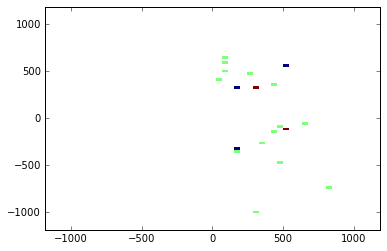

In [31]:
# intersected muons
theta = 2*np.arctan(np.exp(np.array(eta_passed)*(-1)))
r = 3000*np.tan(theta)
x = r*np.cos(phi_passed)
y = r*np.sin(phi_passed)
h_passed, x_edge, y_edge, img = plt.hist2d(x, y, bins=[2*1185/43,2*1185/29], range=[[-1185,1185], [-1185,1185]], cmin = 0.0001)

In [32]:
H = h_passed/h_all

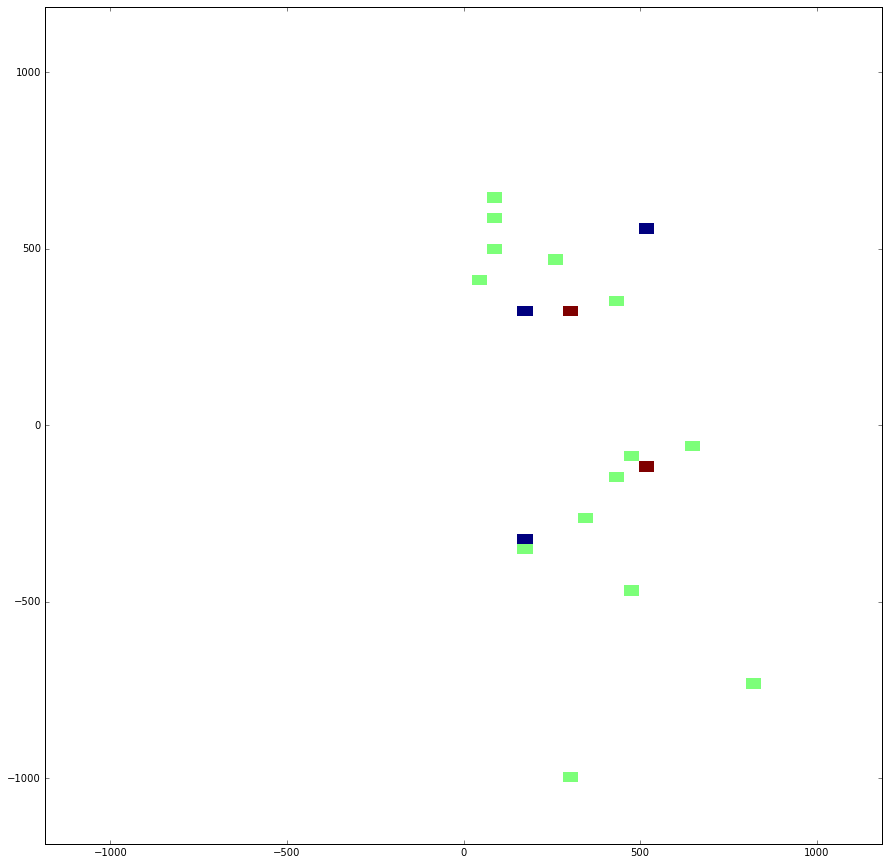

In [33]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(H.T, interpolation='nearest', origin='low',extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])
#plt.imshow(H.T, interpolation='nearest', origin='low',extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])

In [138]:
import random
x_all = np.array([])
y_all = np.array([])
x_TDR_passed = np.array([])
y_TDR_passed = np.array([])
x_TAMALES_passed = np.array([])
y_TAMALES_passed = np.array([])

eta_max = 2.950
eta_min = 1.659
eta_range = eta_max-eta_min
theta_max = 2*np.arctan(np.exp(eta_max*(-1)))
theta_min = 2*np.arctan(np.exp(eta_min*(-1)))
theta_range = theta_min-theta_max

nEvents = int(1e5)

theta = np.random.rand(nEvents)*theta_range + theta_max
phi = np.random.rand(nEvents)*2*np.pi - np.pi
r = 3000*np.tan(theta)
vx = r*np.cos(phi)
vy = r*np.sin(phi)

for x,y in zip(vx,vy):
    #if (i%int(1e5))==0: print i
        
    #eta = random.random()*eta_range + eta_min
    #theta = random.random()*theta_range + theta_max
    #phi = random.random()*2*np.pi - np.pi
    ##theta = 2*np.arctan(np.exp(eta*(-1)))
    #r = 3000*np.tan(theta)
    #x = r*np.cos(phi)
    #y = r*np.sin(phi)
    
    ##x = random.random()*1185*( (-1) if random.random()<0.5 else (1) )
    ##y = random.random()*1185*( (-1) if random.random()<0.5 else (1) )
    
    TDR_intersect = False
    for face in [TDR_face_plus_front1, TDR_face_plus_front2, TDR_face_plus_back1, TDR_face_plus_back2]:
        if face.find_intersection_fast(x/1000,y/1000):
            TDR_intersect = True
            break
    if TDR_intersect:
        x_TDR_passed = np.append(x_TDR_passed, [x])
        y_TDR_passed = np.append(y_TDR_passed, [y])
        
    TAMALES_intersect = False
    for face in [TAMALES_face_plus_front1, TAMALES_face_plus_front2, TAMALES_face_plus_back1, TAMALES_face_plus_back2]:
        if face.find_intersection_fast(x/1000,y/1000):
            TAMALES_intersect = True
            break
    if TAMALES_intersect:
        x_TAMALES_passed = np.append(x_TAMALES_passed, [x])
        y_TAMALES_passed = np.append(y_TAMALES_passed, [y])
            
    x_all = np.append(x_all, [x])
    y_all = np.append(y_all, [y])
    

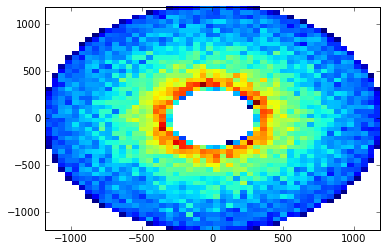

In [139]:
# all muons
h_all, x_edge, y_edge, img = plt.hist2d(x_all, y_all, bins=[50,50], range=[[-1185,1185], [-1185,1185]], cmin = 0.0001)

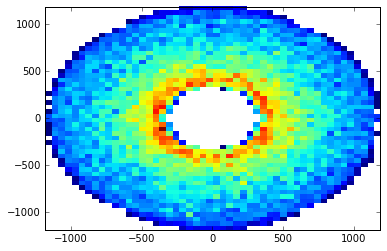

In [140]:
# intersected muons with TDR
h_TDR_passed, x_edge, y_edge, img = plt.hist2d(x_TDR_passed, y_TDR_passed, bins=[50,50], range=[[-1185,1185], [-1185,1185]], cmin = 0.0001)

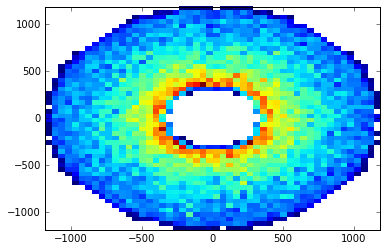

In [141]:
# intersected muons with TAMALES
h_TAMALES_passed, x_edge, y_edge, img = plt.hist2d(x_TAMALES_passed, y_TAMALES_passed, bins=[50,50], range=[[-1185,1185], [-1185,1185]], cmin = 0.0001)

In [142]:
len(TDR_face_plus_back1.x)

2024

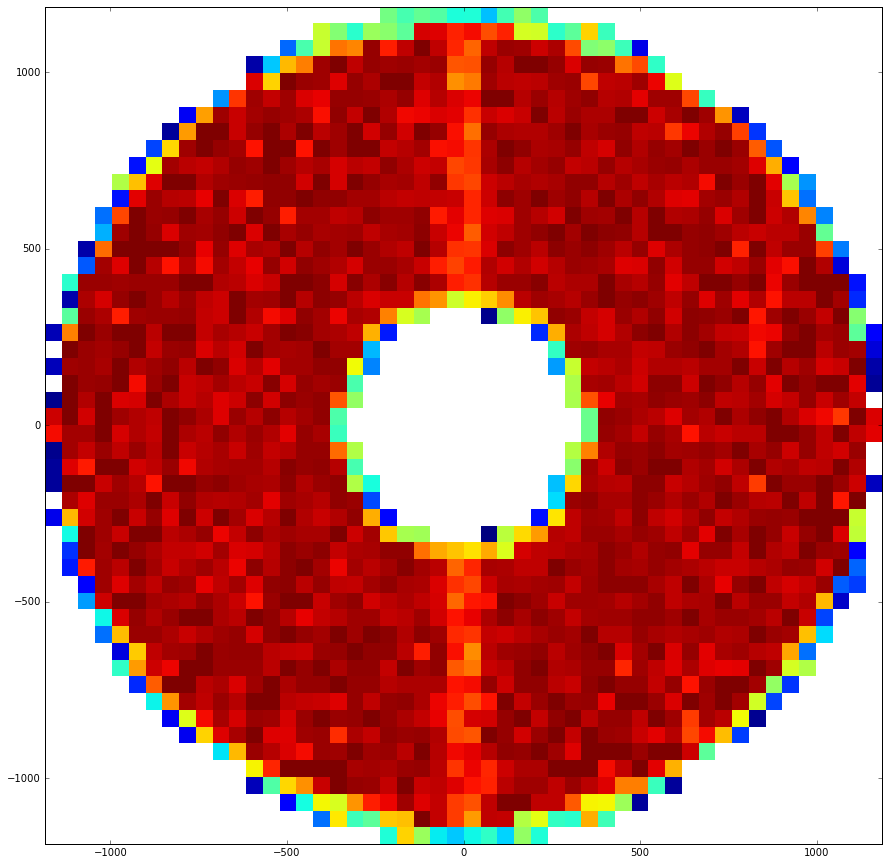

In [143]:
# TDR efficiencies
#H = np.nan_to_num(h_TDR_passed/h_all, 0)
H = h_TDR_passed/h_all
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(H.T, interpolation='nearest', origin='low',extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])


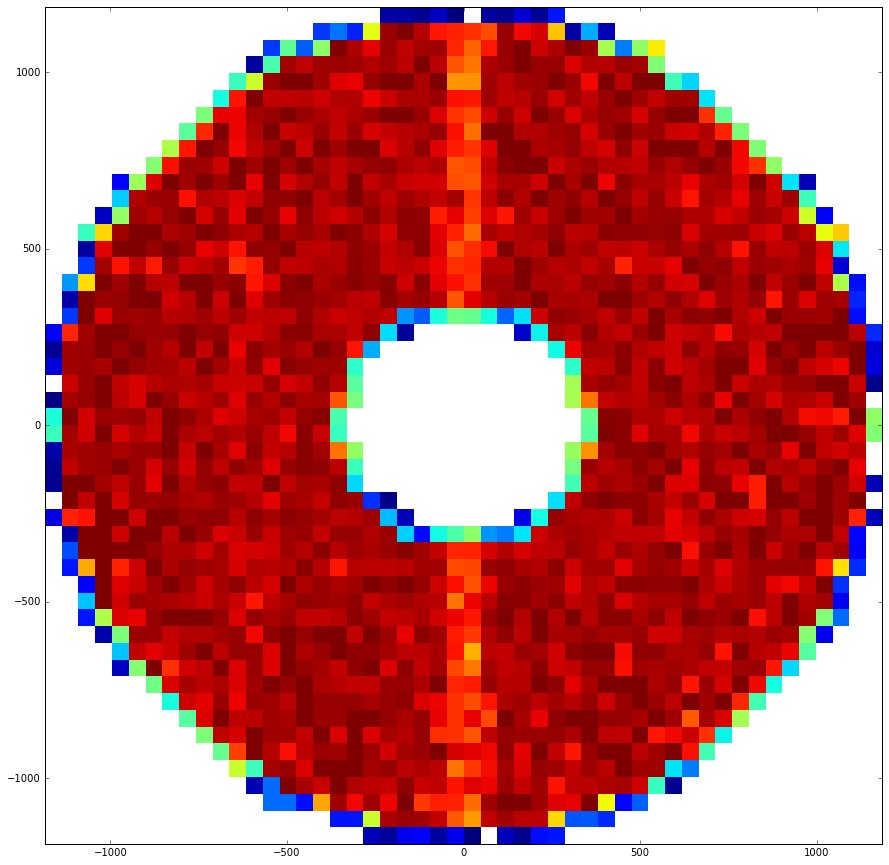

In [144]:
# TAMALES efficiencies
#H = np.nan_to_num(h_TAMALES_passed/h_all, -1)
H = h_TAMALES_passed/h_all
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(H.T, interpolation='nearest', origin='low',extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])



In [145]:
## Overall efficiency

print "# TDR design:"
print "  %.3f"%(float(len(x_TDR_passed))/len(x_all))
print "# TAMALES design:"
print "  %.3f"%(float(len(x_TAMALES_passed))/len(x_all))

# TDR design:
  0.890
# TAMALES design:
  0.891


In [99]:
len(x_TAMALES_passed)

99354

In [ ]:
x_all = np.append(x_all, 2)

In [ ]:
x_all